In [1]:
import os
import numpy as np
import torch
import torchvision as tv
import torch.utils.data as td
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
dataset_root_dir = 'BSDS300/images/'

In [3]:
os.listdir(dataset_root_dir)

['.ipynb_checkpoints', 'train', 'test', 'Arbeit.ipynb']

In [4]:
class NoisyBSDSDataset(td.Dataset):
    def __init__(self, root_dir, mode='train',image_size=(180,180),sigma=30):
        super(NoisyBSDSDataset,self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir,mode)
        self.files = os.listdir(self.images_dir)
        self.levels = 3
        
        
    def __len__(self):
        return len(self.files)
    
    def __repr__(self):
        return f"NOisyBSDSDataset(mode={self.mode}, image_size={self.image_size}, sigma = {self.sigma})"
    
    def quantized_image(self, img):
        img = torch.floor(img*self.levels)/self.levels
        return img
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.images_dir,self.files[idx])
        clean = Image.open(img_path).convert('L')  # converts to grey scale with L as parameters
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        
        clean = clean.crop([i, j, i + self.image_size[0], j + self.image_size[1]])
        
        transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,),(0.5,))
            
        ])
        
        clean = transform(clean)
        quant = self.quantized_image(clean)
        
        #noisy = clean #+ 2/255* self.sigma*torch.randn(clean.shape)
        return quant,clean
    
train_set = NoisyBSDSDataset(root_dir = dataset_root_dir, mode = 'train', image_size = (180,180), sigma = 30)
test_set = NoisyBSDSDataset(root_dir = dataset_root_dir, mode= 'test', image_size = (320,320), sigma = 30)

In [5]:
train_set

NOisyBSDSDataset(mode=train, image_size=(180, 180), sigma = 30)

In [6]:
def myimshow(image,ax = plt):
    image = image.numpy()
    image = np.moveaxis(image,[0,1,2],[2,0,1])
    image = (image+1)/2
    image[image<0] = 0
    image[image>1] = 1
    image =  ax.imshow(image,cmap='gray')
    ax.axis('off')
    return image

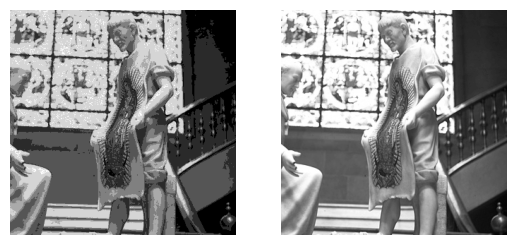

In [7]:
x = test_set[99]
fig,(ax1,ax2) = plt.subplots(ncols=2)
myimshow(x[0],ax = ax1)
myimshow(x[1], ax= ax2)

In [8]:
x= train_set[2]

In [9]:
x[0].dtype

torch.float32

In [10]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)

In [11]:
len(test_set)

100

In [12]:
gpu_id = 1
torch.cuda.set_device(gpu_id)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
batch_size=16
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=False)

In [15]:
class Denoising(nn.Module):
    def __init__(self,num_layers=22,c=64):
        super(Denoising,self).__init__()
        layers = []
        
        layers.append(nn.Conv2d(1,c,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        
        #intermediate layers
        
        for i in range(num_layers-2):
            layers.append(nn.Conv2d(c,c,kernel_size=3,padding=1))
            layers.append(nn.BatchNorm2d(c))
            layers.append(nn.ReLU())
            
        # final layer
        
        layers.append(nn.Conv2d(c,1,kernel_size=3,padding=1))
        self.dncnn = nn.Sequential(*layers)
        
    def forward(self,x):
        y = self.dncnn(x)+x
        return y

In [16]:
model = Denoising().to(device)
print(model)


Denoising(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
num_epochs = 10

In [18]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for (noisy, clean) in train_loader:
        noisy = noisy.to(device)
        clean = clean.to(device)
        optimizer.zero_grad()
        denoised = model(noisy)
        loss = criterion(denoised,clean)
        loss.backward()
        optimizer.step()
        running_loss+= loss.item()
        
    print(f"Epoch{epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch1/10, Loss: 0.09228526679082559
Epoch2/10, Loss: 0.012071207452278871
Epoch3/10, Loss: 0.010734303639485286
Epoch4/10, Loss: 0.009944457775698258
Epoch5/10, Loss: 0.009893553044933539
Epoch6/10, Loss: 0.009977764306733241
Epoch7/10, Loss: 0.00973905587139038
Epoch8/10, Loss: 0.00950839313176962
Epoch9/10, Loss: 0.009651017017089404
Epoch10/10, Loss: 0.00985336468483393


In [19]:
torch.cuda.mem_get_info()

(4686610432, 11546394624)

In [20]:
current_device = torch.cuda.current_device()
current_device

1

In [31]:
model.eval()

def Show_Image(idx):
    noisy,clean = test_set[idx]
    noisy = noisy.to(device)
    clean = clean.to(device)
    
    with torch.no_grad():
        denoised = model(noisy.unsqueeze(0))[0]
        fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(15,7),sharex= 'all',sharey = 'all')
        axes[0].set_title("Noisy")
        myimshow(noisy.cpu(),axes[0])
        
        axes[1].set_title("Denoised")
        myimshow(denoised.cpu(),axes[1])
        
        axes[2].set_title("Clean")
        myimshow(clean.cpu(),axes[2])
        
    

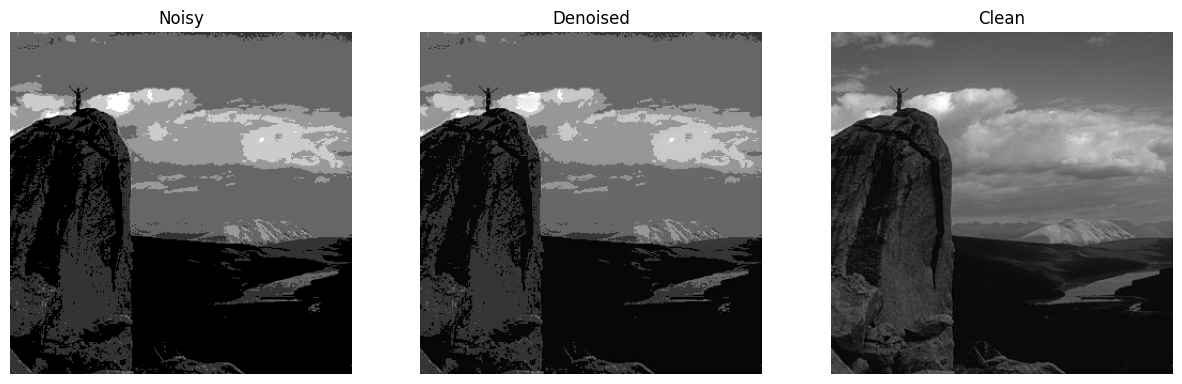

In [32]:
Show_Image(15)
plt.savefig('Quantized.png')

In [23]:
x = test_set[25]

In [24]:
x[0].shape

torch.Size([1, 320, 320])

In [25]:
x[0]

tensor([[[-0.6667, -0.6667, -0.6667,  ..., -0.6667, -0.6667, -0.6667],
         [-0.6667, -0.6667, -0.6667,  ..., -0.6667, -0.6667, -0.6667],
         [-0.6667, -0.6667, -0.6667,  ..., -0.6667, -0.6667, -0.6667],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.6667, -0.6667, -0.6667],
         [-1.0000, -1.0000, -0.6667,  ..., -0.6667, -0.6667, -0.6667],
         [-0.6667, -0.6667, -0.6667,  ..., -0.3333, -0.3333, -0.3333]]])